# Part I: Encoding images into StyleGAN's latent space

![alt text](https://miro.medium.com/max/1280/0*eeFaGLx96mlbQcrK.gif)

## Before you move on, make sure you have GPU acceleration enabled:
> ### Click 'Runtime' in the menu tab at the top
> ### Click 'Change runtime type'
> ### Make sure the hardware accelerator is set to 'GPU'

# This is a hosted IPython notebook
### For those not familiar, all you really need to know is:
* There are text cells (like this one) 
* And Python code cells (like the one below)
* If you want the full tutorial, you can find it here: https://colab.research.google.com/notebooks/welcome.ipynb

### To run a code cell, simply click inside it and hit "shift+enter"
(hitting shift + enter repeatedly will run through all the cells sequentially)
### Don't worry if you're new to this: 
> If things don't work, you can always click "Runtime-->Reset all runtimes" and restart the whole notebook if you mess up!

In [1]:
# This is a cell with Python code
# Execute the cell by clicking inside it and hitting shift+enter, or by clicking the 'run' button on the left of this cell

a = 20
b = 30
c = a+b
print("The sum of %d and %d is %d." %(a,b,c))

The sum of 20 and 30 is 50.


### Let's first clone the Github repo we'll use: https://github.com/pbaylies/stylegan-encoder

In [2]:
!rm -rf sample_data
!git clone https://github.com/pbaylies/stylegan-encoder

'rm' is not recognized as an internal or external command,
operable program or batch file.
Cloning into 'stylegan-encoder'...


### cd into the repo folder: (only run this cell once or things might get buggy)

In [0]:
cd stylegan-encoder

/content/stylegan-encoder


### Let's see the files inside the repo we just cloned:

In [0]:
ls

align_images.py                        Play_with_latent_directions.ipynb
config.py*                             pretrained_example.py*
dataset_tool.py*                       README.md*
dnnlib/                                requirements.txt
encode_images.py                       run_metrics.py*
encoder/                               StyleGAN_Encoder_Tutorial.ipynb
ffhq_dataset/                          swa.py
generate_figures.py*                   teaser.png
Learn_direction_in_latent_space.ipynb  train_effnet.py
LICENSE.txt*                           training/
metrics/                               train.py*
mona_example.jpg                       train_resnet.py


### Some housekeeping: setting up folder structure for our images:

In [0]:
rm -rf aligned_images raw_images

In [0]:
mkdir aligned_images raw_images

# I. Get Images:

## Some tips for the images:


*   Use HD images (preferably > 1000x1000 pixels)
*   Make sure your face is not too small
*   Neutral expressions & front facing faces will give better results
*   Clear, uniform lighting conditions are also recommened



## Option 1: Upload Images manually (usually gives the best results)



*   Click the '>' icon in the panel on the top left 
*   Go to the 'Files' tab
*   Unfold the stylegan-encoder folder (left-click)
*   Right click the 'stylegan-encoder/raw_images' folder and click "upload"
*   I'd recommend starting with 3 - 6 different images containing faces



## Option 2: Take images using your webcam

In [0]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
from PIL import Image
from datetime import datetime

VIDEO_HTML = """
<video autoplay
 width=%d height=%d style='cursor: pointer;'></video>
<script>

var video = document.querySelector('video')

navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""

def take_photo(quality=1.0, size=(800,600)):
  display(HTML(VIDEO_HTML % (size[0],size[1],quality)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  f = io.BytesIO(binary)
  img = np.asarray(Image.open(f))
  
  timestampStr = datetime.now().strftime("%d-%b-%Y (%H:%M:%S.%f)")
  filename = 'raw_images/photo_%s.jpeg' %timestampStr
  Image.fromarray(img).save(filename)
  print('Image captured and saved to %s' %filename)

In [0]:
img = take_photo() # click the image to capture a frame!

## Let's check the contents of our image folder before we start:
#### (You can always manually delete images by right clicking on them in the file tab)

Found 2 images in raw_images
['Barack_Obama_photo.jpg', 'khaleesi.jpeg']


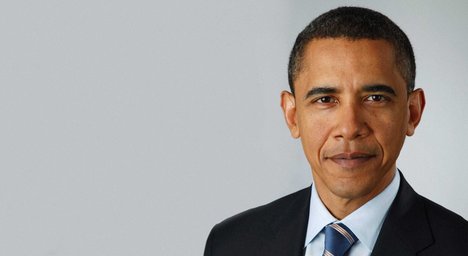

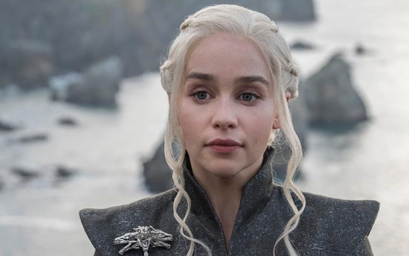

In [0]:
from PIL import Image
import os
imgs = sorted(os.listdir('raw_images'))

print("Found %d images in %s" %(len(imgs), 'raw_images'))
if len(imgs) == 0:
  print("Upload images to the \"raw_images\" folder!")
else:
  print(imgs)

for img_path in imgs:
  img = Image.open('raw_images/' + img_path)
  
  w,h = img.size
  rescale_ratio = 256 / min(w,h)
  img = img.resize((int(rescale_ratio*w),int(rescale_ratio*h)), Image.LANCZOS)
  display(img)

## Make sure we're using the right TensorFlow version (1.15):

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

# II. Auto-Align faces:
### This script wil:


1.   Look for faces in the images
2.   Crop out the faces from the images
3.   Align the faces (center the nose and make the eyes horizontal)
4.   Rescale the resulting images and save them in "aligned_images" folder

### The cell below takes about a minute to run



In [0]:
!python align_images.py raw_images/ aligned_images/ --output_size=1048

Using TensorFlow backend.
64045056/64040097 [==============================] - 5s 0us/step
Aligning khaleesi.jpeg ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/khaleesi_01.png
Aligning Barack_Obama_photo.jpg ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/Barack_Obama_photo_01.png


## Let's take a look at our aligned images:

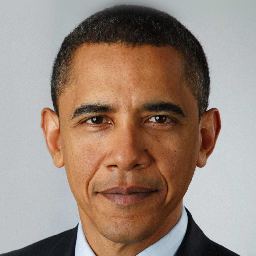

'img 0: Barack_Obama_photo_01.png'

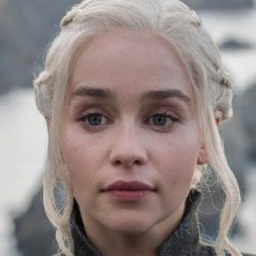

'img 1: khaleesi_01.png'

In [0]:
def display_folder_content(folder, res = 256):
  if folder[-1] != '/': folder += '/'
  for i, img_path in enumerate(sorted(os.listdir(folder))):
    if '.png' in img_path:
      display(Image.open(folder+img_path).resize((res,res)), 'img %d: %s' %(i, img_path))
      print('\n')
      
display_folder_content('aligned_images')

# Important, before moving on:
### Manually clean the 'aligned_images' directory

> ### 1. Manually remove all 'bad' images that are not faces / don't look sharp / clear 
> #####  (Use the image names from the plots above to guide you)
> ### 2. Make sure you don't have too many faces in this folder (8 at most preferably)




# Encoding faces into StyleGAN latent space:

![title](https://raw.githubusercontent.com/pbaylies/stylegan-encoder/master/mona_example.jpg)

## We'll be using pbaylies' awesome encoder repo (building on original work from Puzer): https://github.com/pbaylies/stylegan-encoder


## First, let's download a pretrained resnet encoder: (see video for what this does)
### --> This model takes an image as input and estimates the corresponding latent code

In [0]:
!gdown https://drive.google.com/uc?id=1aT59NFy9-bNyXjDuZOTMl0qX0jmZc6Zb
!mkdir data
!mv finetuned_resnet.h5 data
!rm -rf generated_images latent_representations

Downloading...
From: https://drive.google.com/uc?id=1aT59NFy9-bNyXjDuZOTMl0qX0jmZc6Zb
To: /content/stylegan-encoder/finetuned_resnet.h5
330MB [00:05, 60.1MB/s]


# III. The actual encoding process:
> #### Highly recommended: play with the encoding params: they have a huge effect on the latent representations & images!
> #### Extra encoding options: https://github.com/pbaylies/stylegan-encoder/blob/master/encode_images.py

#### Note: This script will also download:


*   The pretrained StyleGAN network from NVIDIA trained on faces
*   A pretrained VGG-16 network, trained on ImageNet

#### After guessing the initial latent codes using the pretrained ResNet, it will run gradient descent to optimize the latent faces!
#### Note that by default, we're optimizing w vectors, not z-vectors!


In [0]:
print("aligned_images contains %d images ready for encoding!" %len(os.listdir('aligned_images/')))

aligned_images contains 2 images ready for encoding!


#### For best performance, set the batch_size argument below equal to the number of aligned_images (see previous cell)
> Keep batch_size<8 or the GPU might run out of memory (Colab runs on Tesla K80's)

### Depending on the settings, the encoding process might take a few minutes...

In [0]:
!python encode_images.py --batch_size=2 --output_video=True --load_resnet='data/finetuned_resnet.h5' --lr=0.01 --decay_rate=0.8 --iterations=200 --use_l1_penalty=0.3 aligned_images/ generated_images/ latent_representations/
print("\n************ Latent code optimization finished! ***************")




Using TensorFlow backend.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

2019-09-13 11:50:38.155752: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or set the envvar XLA_FLAGS=--xla_hlo_profile.


58892288/58889256 [==============================] - 2s 0us/step
  0% 0/1 [00:00<?, ?it/s]Loading ResNet Model:



  0% 0/200 [00:00<?, ?it/s]WARNING:tensorflow:From /content/stylegan-encoder/encoder/perceptual_model.py:238: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

Instructions for updating:
This op will be removed after the deprecation da

## Showtime!
### Let's load the StyleGAN network into memory:

In [0]:
import dnnlib, pickle
import dnnlib.tflib as tflib
tflib.init_tf()
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=1)

model_dir = 'cache/'
model_path = [model_dir+f for f in os.listdir(model_dir) if 'stylegan-ffhq' in f][0]
print("Loading StyleGAN model from %s..." %model_path)

with dnnlib.util.open_url(model_path) as f:
  generator_network, discriminator_network, averaged_generator_network = pickle.load(f)
  
print("StyleGAN loaded & ready for sampling!")

Loading StyleGAN model from cache/263e666dc20e26dcbfa514733c1d1f81_karras2019stylegan-ffhq-1024x1024.pkl...
StyleGAN loaded & ready for sampling!


In [0]:
def generate_images(generator, latent_vector, z = True):
    batch_size = latent_vector.shape[0]
    
    if z: #Start from z: run the full generator network
        return generator.run(latent_vector.reshape((batch_size, 512)), None, randomize_noise=False, **synthesis_kwargs)
    else: #Start from w: skip the mapping network
        return generator.components.synthesis.run(latent_vector.reshape((batch_size, 18, 512)), randomize_noise=False, **synthesis_kwargs)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_imgs(model, rows, columns):
  for i in range(rows):
    f, axarr = plt.subplots(1,columns, figsize = (20,8))
    for j in range(columns):
      img = generate_images(model, np.random.randn(1,512), z = True)[0]
      axarr[j].imshow(img)
      axarr[j].axis('off')
      axarr[j].set_title('Resolution: %s' %str(img.shape))
    plt.show()

## Let's plot some random StyleGAN samples:

In [0]:
plot_imgs(averaged_generator_network, 3, 3)

Output hidden; open in https://colab.research.google.com to view.

# Let's take a look at the results of our encoding:
### If the results don't look great: Play with the encoding arguments!!!
> 1. Run the optimization for more iterations (eg 1000)
> 2. Decrease the L1 penalty (to eg 0.1)
> 3. Try a lower initial learning rate (eg 0.005) or play with the decay_rate
> 4. Find out about the other encoding options here: https://github.com/pbaylies/stylegan-encoder/blob/master/encode_images.py

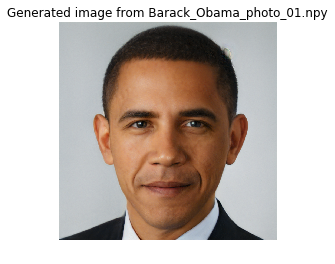

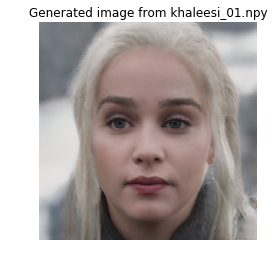

In [0]:
import numpy as np

for f in sorted(os.listdir('latent_representations')):
  w = np.load('latent_representations/' + f).reshape((1,18,-1))
  img = generate_images(averaged_generator_network, w, z = False)[0]
  plt.imshow(img)
  plt.axis('off')
  plt.title("Generated image from %s" %f)
  plt.show()

## Let's compare our encoded samples with the original ones:

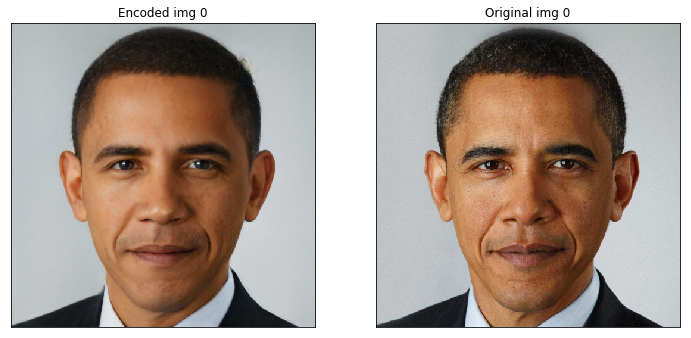

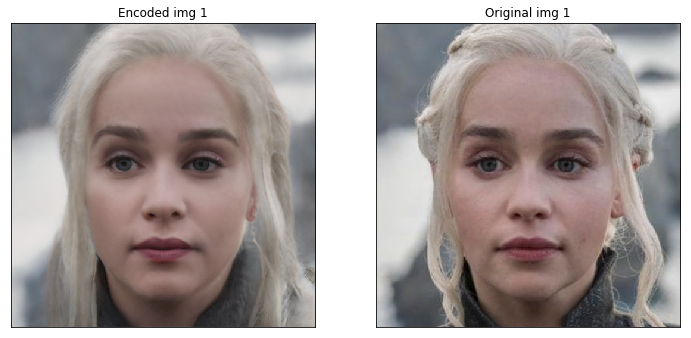

In [0]:
import matplotlib.pyplot as plt

def plot_two_images(img1,img2, img_id, fs = 12):
  f, axarr = plt.subplots(1,2, figsize=(fs,fs))
  axarr[0].imshow(img1)
  axarr[0].title.set_text('Encoded img %d' %img_id)
  axarr[1].imshow(img2)
  axarr[1].title.set_text('Original img %d' %img_id)
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.show()

def display_sbs(folder1, folder2, res = 256):
  if folder1[-1] != '/': folder1 += '/'
  if folder2[-1] != '/': folder2 += '/'
    
  imgs1 = sorted([f for f in os.listdir(folder1) if '.png' in f])
  imgs2 = sorted([f for f in os.listdir(folder2) if '.png' in f])
  if len(imgs1)!=len(imgs2):
    print("Found different amount of images in aligned vs raw image directories. That's not supposed to happen...")
  
  for i in range(len(imgs1)):
    img1 = Image.open(folder1+imgs1[i]).resize((res,res))
    img2 = Image.open(folder2+imgs2[i]).resize((res,res))
    plot_two_images(img1,img2, i)
    print("")
     
display_sbs('generated_images/', 'aligned_images/', res = 512)

### Note: 
If you want to watch the whole thing unfold for yourself, you can **download the optimization videos** from the "videos" folder

# IV. Cherry pick images & dump their latent vectors to disk
### Manipulating latent vectors (Notebook II) is tricky and will only work well if the face encoding looks 'good'
### Cherry pick a few images where the optimization worked well
> (Use the image indices from the plot titles above)

In [0]:
good_images = [0,1]  #Change these numbers to pick out latents that worked well (see the image plots)

## Save these latent vectors to disk:

In [0]:
import numpy as np
latents = sorted(os.listdir('latent_representations'))

out_file = '/content/output_vectors.npy'

final_w_vectors = []
for img_id in good_images:
  w = np.load('latent_representations/' + latents[img_id])
  final_w_vectors.append(w)

final_w_vectors = np.array(final_w_vectors)
np.save(out_file, final_w_vectors)
print("%d latent vectors of shape %s saved to %s!" %(len(good_images), str(w.shape), out_file))

2 latent vectors of shape (18, 512) saved to /content/output_vectors.npy!


# V. Manipulating the faces
### Everything we downloaded / saved to disk is currently on a temporary VM running on Google Colab
### (which can be accessed through another notebook you run)
> If you want to reuse the latent vectors later, you can download them manually **(highly recommended!!)** :
>> * Go to the root directory using the Files browser
>> * Richt-click & Download the latent representations: "output_vectors.npy"
## Next, let's continue with notebook II:
> ### Simply open the second notebook from the Drive folder and continue the guide-steps
> ### (Hint: Notebook II is where all the fun is!)

![alt text](https://66.media.tumblr.com/tumblr_mc3hg5VpQP1qcy0p7o1_400.gif)